# Forecasting Sales of `CELIACS Segment` with the Holt-Winters Method

In [1]:
# dataframe opertations
import pandas as pd
import numpy as np
# plotting data - matplotlib
import matplotlib.pyplot as plt
import matplotlib as mpl
# time series - statsmodels 
# Seasonality decomposition
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import seasonal_decompose 
# holt winters 
# single exponential smoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing   
# double and triple exponential smoothing
from statsmodels.tsa.holtwinters import ExponentialSmoothing

#evaluation metrics
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error

#Ignore the warning, can comment this 
import warnings
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['text.color'] = 'k'

pd.options.display.float_format = '{:,}'.format
pd.options.display.float_format = "{:,.2f}".format

/Users/emi/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Uploading data and indexing by time

In [2]:
# Import the data
data = pd.read_csv("data.csv")

In [3]:
#making a copy to not change the original df 
df = data.copy()

In [4]:
df.head(2)

,Unnamed: 0,store_code,week_code,prod_code,units_sold,sales_(€),sales_volume_(lt),real_unit_price,real_volume_price,rate_price_in_units,...,brand,packaging,volume_(ml),units_(ct),province,autonomous_community,min_temp,max_temp,avg_temp,precipitation_(mm)
0,0,243,42,236,30,19.50,10,0.65,0.33,0.65,...,MAN 2 - BRAND 1,CAN,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29
1,1,243,42,239,2,1.82,1,0.91,0.33,0.91,...,MAN 2 - BRAND 1,CRISTAL BOTTLE,330,1,La Rioja,La Rioja,5.67,12.29,8.80,1.29


In [5]:
#slicing based on desired segment to forecast
df = df[df.segment == 'CELIACS']

#making sure that we are only handling the CELIACS segment
df['segment'].unique()

array(['CELIACS'], dtype=object)

In [6]:
#selecting columns to work with
df = df[['date', 'sales_(€)']]
df.head()

,date,sales_(€)
127,2020-10-18,0.84
128,2020-10-18,12.88
129,2020-10-18,4.62
207,2020-10-18,9.79
271,2020-10-18,0.86


In [7]:
#checking shape of df
df.shape

(106220, 2)

In [8]:
#date to datetime object
df['date'] = pd.to_datetime(df['date'])

#grouping by week to get total weekly sales
df = df.groupby(['date'])['sales_(€)'].sum().to_frame()

#check output
df.head()

,sales_(€)
date,
2020-01-05,"6,706.64"
2020-01-12,"6,793.98"
2020-01-19,"7,176.60"
2020-01-26,"7,088.29"
2020-02-02,"8,102.96"


In [9]:
#final df must have 120 weeks of data rocorded
df.shape

(120, 1)

## Visualizing the data

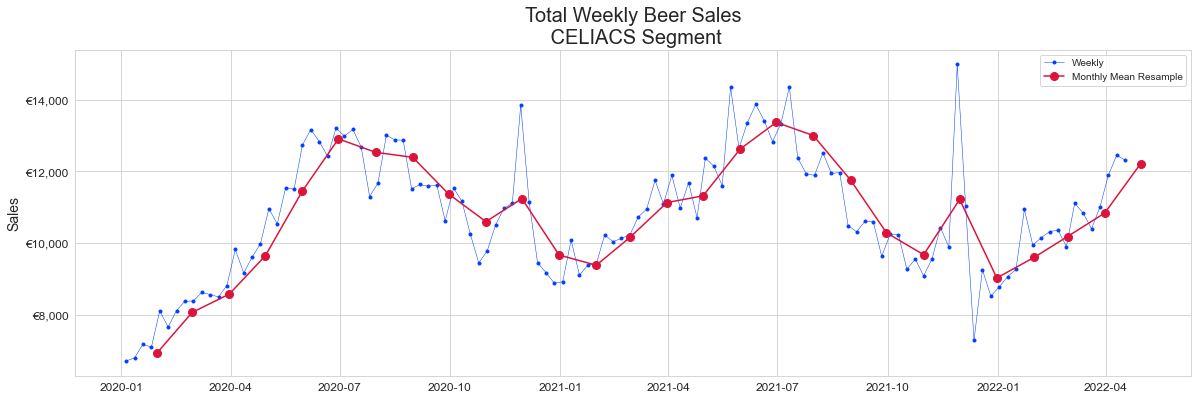

In [10]:
import seaborn as sns
sns.set_style("whitegrid")

import warnings
import matplotlib.pyplot as plt
y = df['sales_(€)']

fig, ax = plt.subplots(figsize=(20, 6))

ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', 
        markersize=8, linestyle='-', 
        label='Monthly Mean Resample', 
        color='crimson')

plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_title("Total Weekly Beer Sales\n CELIACS Segment", fontsize=20)
ax.set_ylabel('Sales')
ax.legend();

## Decomposing the Data

In [13]:
import statsmodels.api as sm

# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

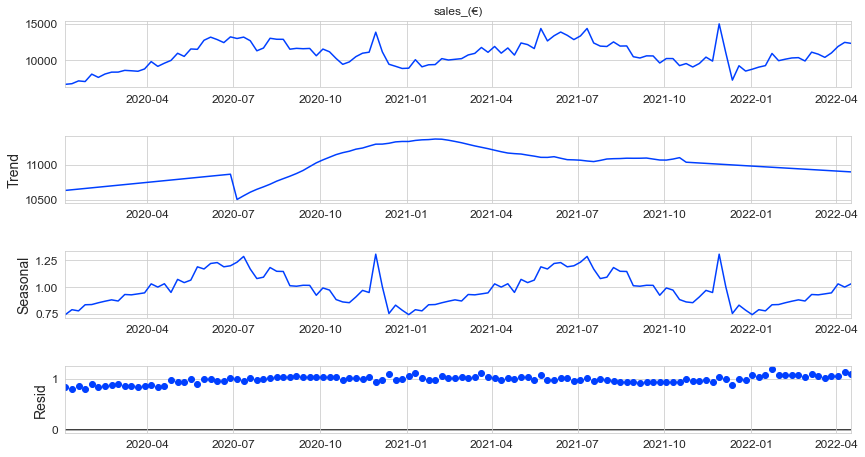

In [14]:
seasonal_decompose(y)

# Single HWES

In [15]:
# Set the frequency of the date time index as Monthly start as indicated by the data
df.index.freq = "W"

# Set the value of Alpha and define m (Time Period)
m = 52
alpha = 1/(2*m)

#fitting the model
df['HWES1'] = SimpleExpSmoothing(df['sales_(€)']).fit(smoothing_level=alpha,optimized=False,use_brute=True).fittedvalues

MAPE% on fitted values HW Single Exp Smoothing = 21.92%


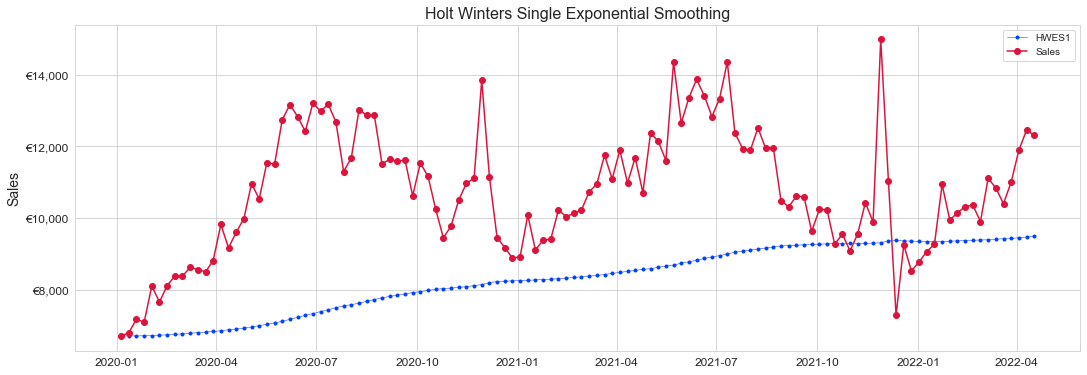

In [16]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES1'],marker='.', linestyle='-', linewidth=0.5, label='HWES1')
ax.plot(df['sales_(€)'],marker='o', markersize=6, linestyle='-', label='Sales', color='crimson')
ax.set_title(f"Holt Winters Single Exponential Smoothing", fontsize=16)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metric
mape_HWES1 = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES1'])*100, 2)

#printing evaluation metric
print(f'MAPE% on fitted values HW Single Exp Smoothing = {mape_HWES1}%')

## Observations
As expected, it didn’t fit quite well, and rightfully so, because if we remember, Single ES doesn’t work for data with Trends and Seasonality. 
Based on the decomposition of the data we have an upwards trend and we can also see a monthly seasonality

# Double HWES

In [17]:
df['HWES2_ADD'] = ExponentialSmoothing(df['sales_(€)'],trend='add').fit().fittedvalues

df['HWES2_MUL'] = ExponentialSmoothing(df['sales_(€)'],trend='mul').fit().fittedvalues

df[['sales_(€)','HWES2_ADD','HWES2_MUL']]

,sales_(€),HWES2_ADD,HWES2_MUL
date,,,
2020-01-05,"6,706.64","6,552.46","6,693.61"
2020-01-12,"6,793.98","6,728.96","6,934.17"
2020-01-19,"7,176.60","6,851.66","7,080.15"
2020-01-26,"7,088.29","7,136.99","7,385.75"
2020-02-02,"8,102.96","7,193.22","7,439.71"
...,...,...,...
2022-03-20,"10,399.56","10,815.13","10,873.97"
2022-03-27,"11,005.97","10,575.98","10,621.67"
2022-04-03,"11,893.27","10,858.87","10,914.69"


MAPE% for fitted values HWS2_ADD = 6.15%
MAPE% for fitted values HWS2_MUL = 6.33%


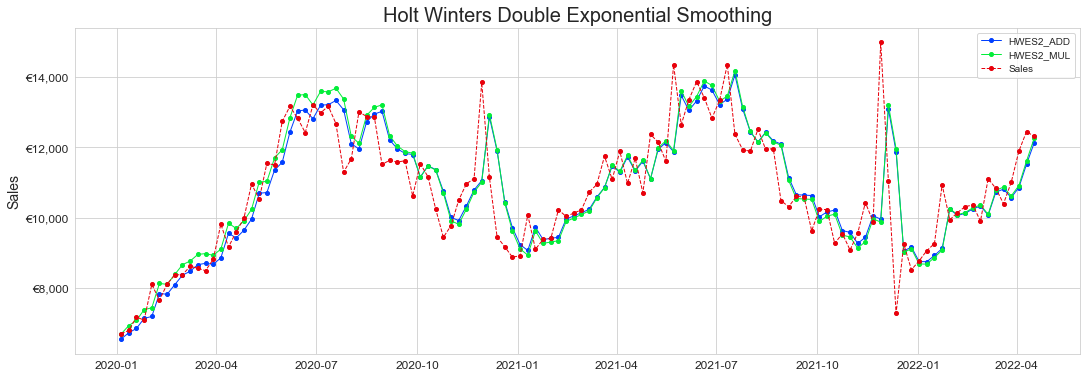

In [18]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES2_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_ADD')
ax.plot(df['HWES2_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES2_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales')
ax.set_title("Holt Winters Double Exponential Smoothing", fontsize=20)
ax.set_ylabel('Sales')
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.legend();

#evaluation metrics
mape_HWS2_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_ADD'])*100, 2)
mape_HWS2_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES2_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS2_ADD = {mape_HWS2_ADD}%')
print(f'MAPE% for fitted values HWS2_MUL = {mape_HWS2_MUL}%')

### Observations
Well, this looks a little better, but since we know there is Seasonality, we shall move into Triple ES and look at how it fits.

# Triple HWES

In [19]:
#Triple HWES helps us include a seasonal periods
#the seasonal parameter for out data is s=52 (the one attributed to data with weekly seasonality)

df['HWES3_ADD'] = ExponentialSmoothing(df['sales_(€)'], trend='add',seasonal='add',seasonal_periods=52).fit().fittedvalues

df['HWES3_MUL'] = ExponentialSmoothing(df['sales_(€)'], trend='mul',seasonal='mul',seasonal_periods=52).fit().fittedvalues

df[['HWES3_ADD', 'HWES3_MUL', 'sales_(€)']]

,HWES3_ADD,HWES3_MUL,sales_(€)
date,,,
2020-01-05,"7,826.90","8,112.19","6,706.64"
2020-01-12,"8,592.96","8,608.79","6,793.98"
2020-01-19,"7,262.59","7,189.08","7,176.60"
2020-01-26,"7,673.50","7,409.38","7,088.29"
2020-02-02,"7,604.50","7,313.54","8,102.96"
...,...,...,...
2022-03-20,"11,788.50","11,844.82","10,399.56"
2022-03-27,"10,953.26","10,848.31","11,005.97"
2022-04-03,"11,860.72","11,763.06","11,893.27"


MAPE% for fitted values HWS3_ADD = 4.22%
MAPE% for ftted values HWS3_MUL = 3.7%


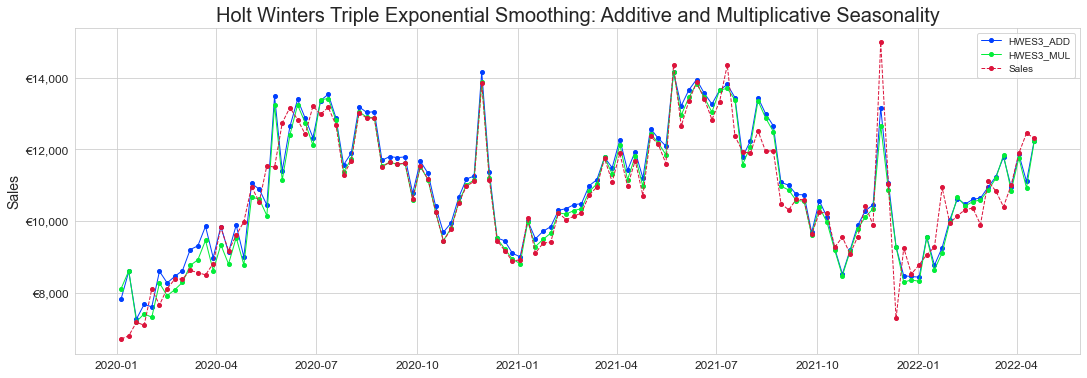

In [20]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(df['HWES3_ADD'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_ADD')
ax.plot(df['HWES3_MUL'],marker='o',markersize=4, linestyle='-', linewidth=1, label='HWES3_MUL')
ax.plot(df['sales_(€)'],marker='o', markersize=4, linestyle='--', linewidth=1, label='Sales', color='crimson')
ax.set_title("Holt Winters Triple Exponential Smoothing: Additive and Multiplicative Seasonality", fontsize=20)
plt.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}')) 
ax.set_ylabel('Sales')

ax.legend();

#evaluation metrics
mape_HWS3_ADD = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_ADD'])*100, 2)
mape_HWS3_MUL = round(mean_absolute_percentage_error(df['sales_(€)'],df['HWES3_MUL'])*100, 2)

#printing evaluation metrics        
print(f'MAPE% for fitted values HWS3_ADD = {mape_HWS3_ADD}%')
print(f'MAPE% for ftted values HWS3_MUL = {mape_HWS3_MUL}%')

# Splitting into Train & Test Set
Why are we sticking with HW Triple Exponential Smoothing?
Because according to the diagnostic plots made in the beginning we know there is Seasonality and a Trend and the MAPE% on fitted values for the `HW Triple ES` indicate the lowest proprotion of error, therefore, this model is the best option for us. 

In [21]:
forecast_data = data.copy() #making a copy of the original df

In [22]:
#slicing based on desired segment to forecast
forecast_data = forecast_data[forecast_data.segment == 'CELIACS']

#making sure that we are only handling the CELIACS segment
forecast_data['segment'].unique()

array(['CELIACS'], dtype=object)

In [23]:
#converting to datetime index
forecast_data['date'] = pd.to_datetime(forecast_data['date'])

#groping by weekly total sales
forecast_data = forecast_data.groupby(['date'])['sales_(€)'].sum().to_frame()

In [24]:
#checking output
forecast_data.head()

,sales_(€)
date,
2020-01-05,"6,706.64"
2020-01-12,"6,793.98"
2020-01-19,"7,176.60"
2020-01-26,"7,088.29"
2020-02-02,"8,102.96"


In [25]:
#final df must have 120 rows of recorded data
forecast_data.shape

(120, 1)

In [26]:
#Let's split our data with the traditional 80/20 split
#Since we are dealing with time series data the order to the records must be kept intact

train = forecast_data[:105]  # taking 105 data points as train-set (2+ years in weekly sales format)
test = forecast_data[105:] # taking the last 15 data points as test-set 

In [27]:
#checking dates for train-set
print(train.index.min())
print(train.index.max())

2020-01-05 00:00:00
2022-01-02 00:00:00


In [28]:
#checking dates for test-set
print(test.index.min())
print(test.index.max())

2022-01-09 00:00:00
2022-04-17 00:00:00


In [29]:
#shapes must be 105 and 15 respectively
print(train.shape)
print(test.shape)

(105, 1)
(15, 1)


# Fitting the Models to the train data & making forecasts

In [30]:
#creating an empty container to score model evaluation metrics
model_metrics = []

In [31]:
#defining a function to change parameters easily and do a trial and error procedure
def HW_model(trend, seasonal, seasonal_periods, damped, title):
    
    fitted_model = ExponentialSmoothing(train['sales_(€)'],
                                    trend=trend,
                                    seasonal=seasonal,
                                    seasonal_periods=seasonal_periods,
                                    use_boxcox=True,
                                    damped=damped, 
                                    initialization_method="estimated").fit()

    test_predictions = fitted_model.forecast(15) 
    title=title
    
    #plotting
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(train['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Train')
    ax.plot(test['sales_(€)'],marker='o',markersize=4, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=4, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title(f'{title}\nTrain, Test and Predicted Values\n Holt-Winters ({trend}-{seasonal}-seasonal-damped={damped})', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #zooming into test vs predicted
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(test['sales_(€)'], marker='o', markersize=5, linestyle='-', linewidth=1, label='Test', color='limegreen')
    ax.plot(test_predictions, marker='o', markersize=5, linestyle='-', linewidth=1, label='Prediction', color='crimson')
    ax.set_title('Zooming in', fontsize=16)
    ax.set_ylabel('Sales')
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))  
    ax.legend()
    plt.show()

    #saving metrics in variables
    mae = mean_absolute_error(test,test_predictions)
    mse = mean_squared_error(test,test_predictions)
    mape = round(mean_absolute_percentage_error(test,test_predictions)*100, 2)
    rmse = mean_squared_error(test,test_predictions, squared=False)
    
    #printing evaluation metrics        
    print(f'Mean Absolute Error = {mae}')
    print(f'Mean Squared Error = {mse}')
    print(f'MAPE% = {mape}%')
    print(f'RMSE = {rmse}')

    #saving metrics for later comparison
    model_metrics.append({
            "model" : f'HW ({trend}-{seasonal}-seasonal-damped={damped})',
            "MAE" : mae,
            "MSE": mse, 
            "MAPE": f'{mape}%', 
            "RMSE": f'{rmse}'
    })

## Holt-Winters (mul-mul-seasonal)

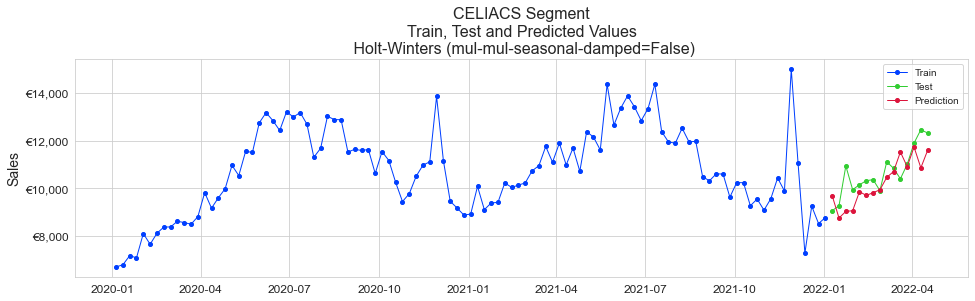

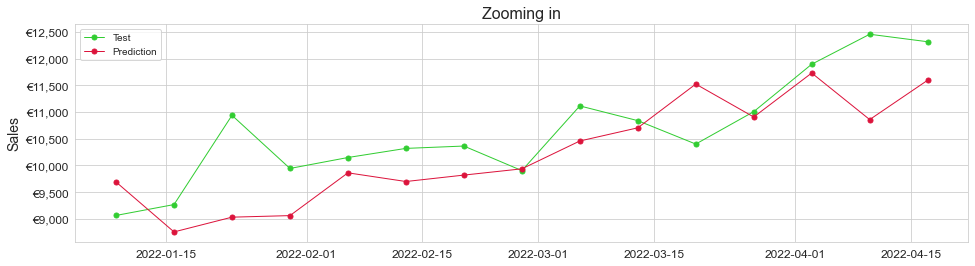

Mean Absolute Error = 660.115672555539
Mean Squared Error = 709162.2516692238
MAPE% = 6.13%
RMSE = 842.1177184154385


In [32]:
HW_model('mul', 'mul', 52, False, "CELIACS Segment")

## Holt-Winters (add-add-seasonal)

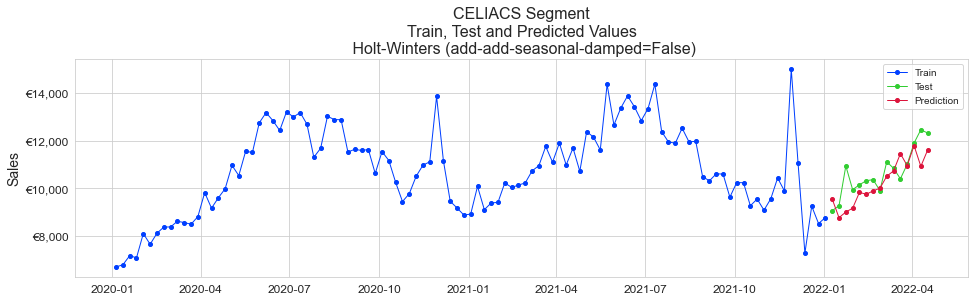

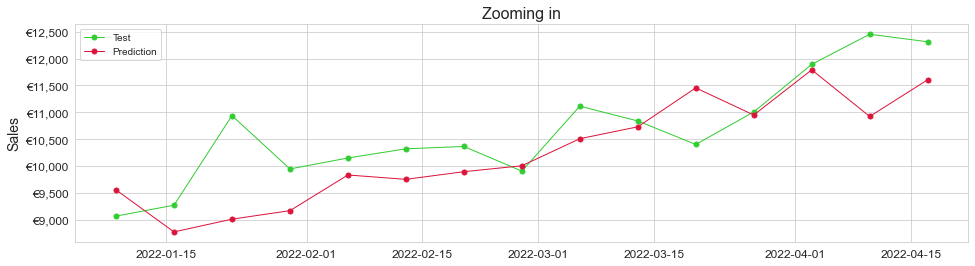

Mean Absolute Error = 621.3234058448477
Mean Squared Error = 655075.5665816198
MAPE% = 5.76%
RMSE = 809.3673866555408


In [33]:
HW_model('add', 'add', 52, False, "CELIACS Segment")

## Holt-Winters (add-add-seasonal-damped)

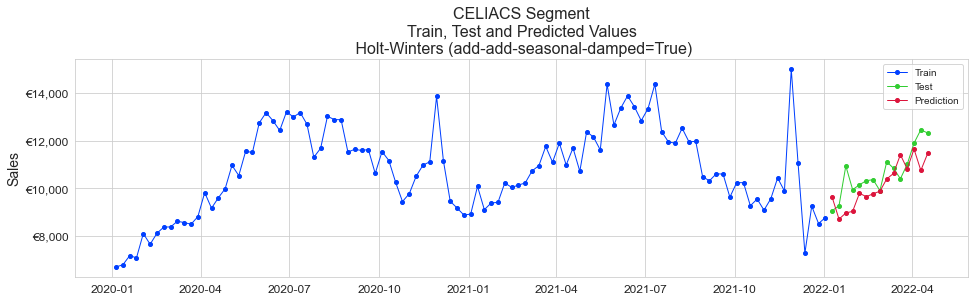

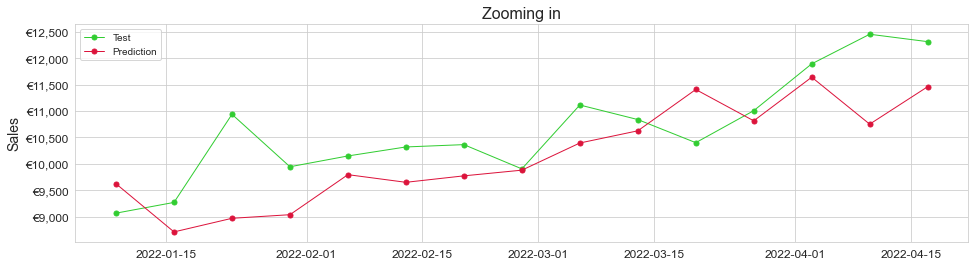

Mean Absolute Error = 705.2871070763433
Mean Squared Error = 771210.952228716
MAPE% = 6.53%
RMSE = 878.1861717362191


In [34]:
HW_model('add', 'add', 52, True, 'CELIACS Segment')

## Holt-Winters (add-mul-seasonal)

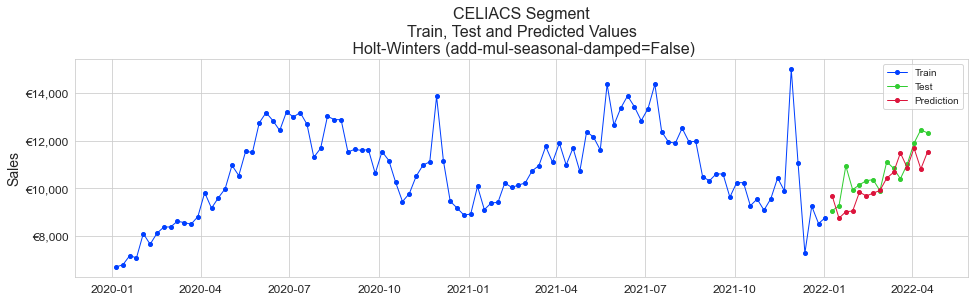

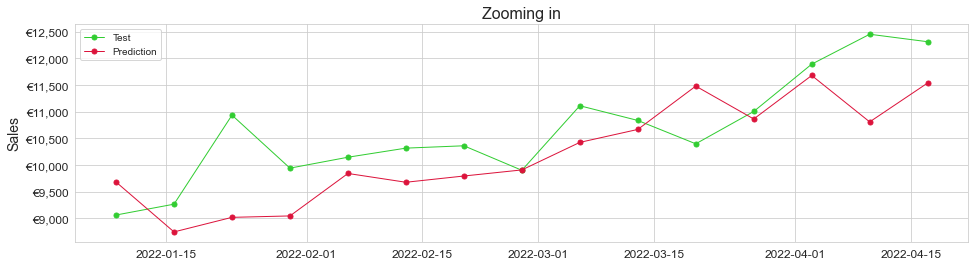

Mean Absolute Error = 678.548920589517
Mean Squared Error = 732700.6101873273
MAPE% = 6.29%
RMSE = 855.9793281308417


In [35]:
HW_model('add', 'mul', 52, False, 'CELIACS Segment')

## Holt-Winters (add-mul-seasonal-damped)

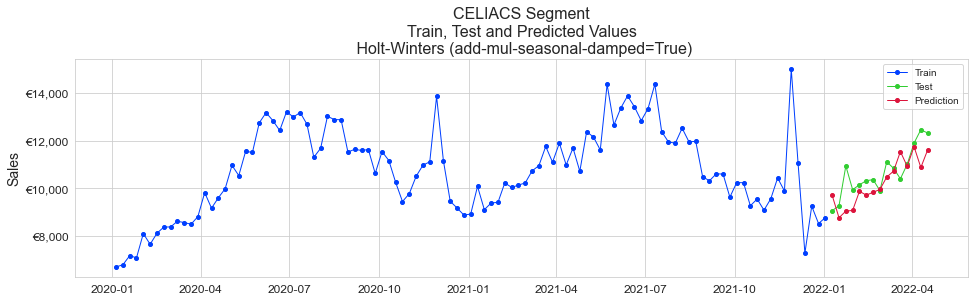

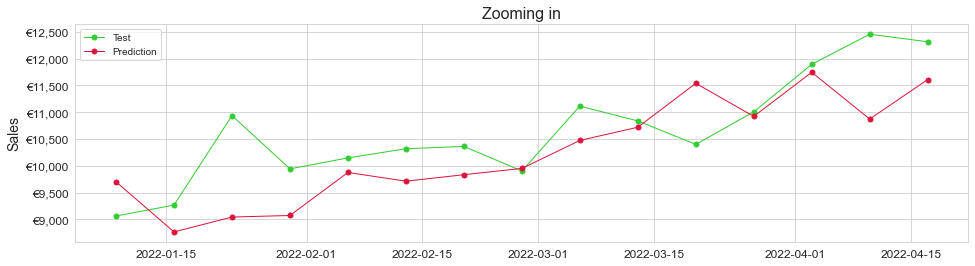

Mean Absolute Error = 651.4507750083778
Mean Squared Error = 697996.1692219316
MAPE% = 6.06%
RMSE = 835.4616503598065


In [36]:
HW_model('add', 'mul', 52, True, "CELIACS Segment")

# Model Comparison

In [37]:
model_metrics
model_metrics_df = pd.DataFrame(model_metrics, 
                                columns = ["model", 
                                           'MSE',
                                           'MAE', 
                                           "MAPE", 
                                           "RMSE"]).set_index("model").sort_values(by=["RMSE"], ascending=True)
model_metrics_df  

,MSE,MAE,MAPE,RMSE
model,,,,
HW (add-add-seasonal-damped=False),"655,075.57",621.32,5.76%,809.3673866555408
HW (add-mul-seasonal-damped=True),"697,996.17",651.45,6.06%,835.4616503598065
HW (mul-mul-seasonal-damped=False),"709,162.25",660.12,6.13%,842.1177184154385
HW (add-mul-seasonal-damped=False),"732,700.61",678.55,6.29%,855.9793281308417
HW (add-add-seasonal-damped=True),"771,210.95",705.29,6.53%,878.1861717362191


## The metric to that is going to decide the overall performance of the model is the MAPE%, this is how it should be interpreted:
* A `MAPE%` of `4.91%` implies the model is `95.09%` accurate in predicting the next 15 observations 

# Forecasting

In [44]:
#defining a function to make forecasts in any range of steps ahead
def final_HW_model(trend, seasonal, seasonal_periods, damped, steps_ahead, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=True, #by changing these parameter we had better simulations
                            initialization_method="estimated").fit()
    
    simulations = fit.simulate(steps_ahead, repetitions=100, error="add")
    
    ax = forecast_data.plot(figsize=(18, 6), marker="o", markersize=4, lw=1)
    ax.set_title(f"Forecast and Simulation for {title}\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})\n Forecast for FY-2023", fontsize=18)
    ax.set_ylabel("Sales")
    ax.set_xlabel(" ")
    plt.ticklabel_format(style='plain', axis='y')
    ax.yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('€{x:,.0f}'))

    fit.fittedvalues.plot(ax=ax, style="--", markersize=3, color="crimson", label='Fitted Values',  legend=True)
    simulations.plot(ax=ax, style="-", alpha=0.05, color="orange", legend=False)
    fit.forecast(steps_ahead).rename(f"Train, Test and Predicted Test\nHolt-Winters ({trend}-{seasonal}-seasonal-damped={damped})").plot(
    ax=ax, style="-", marker="o", markersize=4,  color="crimson", lw=1, legend=True, label='Predictions')
    
    return plt.show()

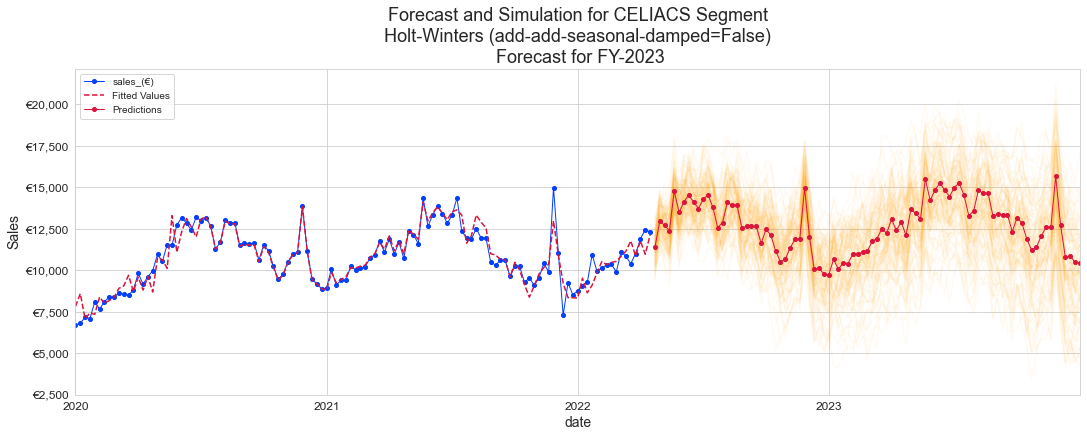

In [45]:
#why are we chooing 89 steps ahead?
    #because those the total steps ahead necesarry to do the forecast until the end of FY-2023
final_HW_model('add', 'add', 52, False, 89, 'CELIACS Segment') 

In [40]:
#defining a function to get quarterly and yearly forecasts in euro value
def forecast_euro_value_until_2023(trend, seasonal, seasonal_periods, damped, title):
    
    #defining variables to describe parameters and specifics of the model and timeframes
    trend = trend
    seasonal = seasonal
    seasonal_periods = seasonal_periods
    damped = damped
    title = title
    
    #fitting the model
    fit = ExponentialSmoothing(forecast_data,
                            trend=trend,
                            seasonal=seasonal,
                            seasonal_periods=seasonal_periods, 
                            damped=damped,
                            use_boxcox=False, 
                            initialization_method="estimated").fit()


    #making the forecast and putting values in inside a dataframe
    forecast = fit.forecast(89).to_frame().reset_index()

    #rename columns for more readability
    forecast.rename(columns={0: title, 'index': 'date'} ,inplace=True)

    #convert date column to datetime object
    forecast['date'] = pd.to_datetime(forecast['date'])

    #group by quarterly total sales
    return print(forecast.groupby(forecast['date'].dt.to_period('Q'))[title].sum().to_frame()), print(forecast.groupby(forecast['date'].dt.to_period('Y'))[title].sum().to_frame())

In [41]:
# calling the function
forecast_euro_value_until_2023('add', 'add', 52, False, "CELIACS_segment_sales")

        CELIACS_segment_sales
date                         
2022Q2             137,294.74
2022Q3             181,471.25
2022Q4             164,527.32
2023Q1             165,169.84
2023Q2             207,570.80
2023Q3             215,357.38
2023Q4             212,178.13
      CELIACS_segment_sales
date                       
2022             483,293.32
2023             800,276.14


(None, None)